In [1]:
import torch, time, copy
import torch.nn as nn
import torch.optim as optim
from torch.quantization import prepare, convert
from src.utils import *
from src.override_resnet import *
import matplotlib.pyplot as plt

def fuse_ALL(model) -> nn.Module:
    SingleTimeFlag = False
    for m in model.modules():
        if m.__class__.__name__ == ResNet_quan.__name__:
            if SingleTimeFlag == True:
                raise ValueError("ResNet_quan is already fused")
            SingleTimeFlag = True
            torch.quantization.fuse_modules(
                m,
                ["conv1", "bn1", "relu"],
                inplace=True,
            )

        if type(m) == BottleNeck_quan:

            torch.quantization.fuse_modules(
                m,
                [
                    ["conv1", "bn1", "relu1"],
                    ["conv2", "bn2", "relu2"],
                    ["conv3", "bn3"],
                ],
                inplace=True,
            )
            if m.downsample is not None:
                torch.quantization.fuse_modules(
                    m.downsample,
                    ["0", "1"],
                    inplace=True,
                )
    return model

In [2]:
device = "cpu"
model = resnet50(weights=pretrained_weights_mapping[50])
model.to(device)
model.eval()

# set fuse ############################################################
model = fuse_ALL(model)

model.fc.qconfig = torch.quantization.QConfig(
    activation=torch.quantization.RecordingObserver.with_args(dtype=torch.qint8),
    weight=None,
)

# model.fc.qconfig.activation()

_= prepare(model, inplace=True)


In [3]:

# calibrate the model ############################################################
criterion = nn.CrossEntropyLoss()
train_loader, _ = GetDataset(
    dataset_name="ImageNet",
    device=device,
    root="data",
    batch_size=32,
    num_workers=8,
)


limit = 5
with torch.no_grad():
    for images, _ in tqdm.tqdm(train_loader):
        images = images.to(device)
        _ = model(images)
        
        limit -= 1
        if limit == 0:
            break

  0%|          | 4/40037 [00:06<18:41:08,  1.68s/it]


In [4]:
for name, module in model.named_modules():
    if hasattr(module, "qconfig"):
        if module.qconfig is not None:
            print(f"{name} | {module.qconfig}")
        

fc | QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.RecordingObserver'>, dtype=torch.qint8){}, weight=None)


In [5]:
dja = model.fc.activation_post_process.get_tensor_value()
dja

[tensor([[-0.1203,  0.1233,  0.0336,  ..., -0.2036, -0.0235, -0.0132],
         [-0.3115, -0.1353, -0.1271,  ..., -0.4849, -0.3095, -0.3258],
         [-0.0828,  0.0466,  0.1666,  ..., -0.2024,  0.2056,  0.1820],
         ...,
         [-0.0240, -0.3219, -0.0908,  ..., -0.1654, -0.1901, -0.7518],
         [-0.7953,  0.0513,  0.3039,  ..., -0.3154,  0.0264,  0.3953],
         [ 0.0808, -0.2136, -0.6095,  ...,  0.3736,  0.2438, -0.0453]]),
 tensor([[-0.3249, -0.4925, -0.1859,  ..., -0.5560, -0.2646, -0.5556],
         [ 0.1056,  0.1925,  0.6054,  ..., -0.1301, -0.1398, -0.2341],
         [ 0.4224, -0.0696,  0.1104,  ..., -0.3242, -0.2162, -0.1029],
         ...,
         [-0.5123, -0.5479, -0.4831,  ..., -0.3540, -0.1401,  0.5338],
         [ 2.9835,  0.0136, -0.1299,  ..., -0.1464,  0.3950, -0.5696],
         [-0.0163,  0.0565, -0.2216,  ...,  0.8426, -0.3228, -0.4415]]),
 tensor([[-0.3127, -0.0443, -0.1951,  ..., -0.7393,  0.1579,  0.3965],
         [ 0.1357, -0.0416,  0.1382,  ...,  0

(5, 32, 1000)


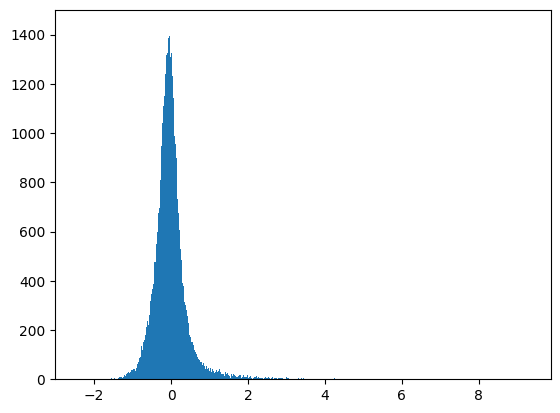

In [19]:
import numpy as np
dja = np.array(dja)
print(dja.shape)
plt.hist(dja.flatten(), bins=2048)
plt.show()